In [1]:
import glob
import math
import numpy as np
from matplotlib import pyplot as plt
from donkeycar.parts.tub_v2 import Tub

________             ______                   _________              
___  __ \_______________  /___________  __    __  ____/_____ ________
__  / / /  __ \_  __ \_  //_/  _ \_  / / /    _  /    _  __ `/_  ___/
_  /_/ // /_/ /  / / /  ,<  /  __/  /_/ /     / /___  / /_/ /_  /    
/_____/ \____//_/ /_//_/|_| \___/_\__, /      \____/  \__,_/ /_/     
                                 /____/                              

using donkey v4.4.3 ...


In [48]:
def read_tub(path):
    tub = Tub(file)
    lines = []
    for record in tub:
        if 'path/waypoints' in record:
            record['path/waypoints'] = np.array(record['path/waypoints'])
        lines.append(record)
    return lines

def column_to_np(tub_data, column):
    data = []
    for line in tub_data:
        data.append(line[column] if column in line else None)
    return np.array(data)

def to_front_pos(x, y, theta, length):
    x_front = x + length / 2 * np.cos(theta)
    y_front = y + length / 2 * np.sin(theta)
    return x_front, y_front

# def get_path_for_pose(pose):
#         translation = self.path_pose[1:3] - pose[1:3]
#         rotation_angle = self.path_pose[3] - pose[3]
#         R = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])
#         return (self.path + translation) @ R

In [66]:
tubs = glob.glob("./data/tub*")
tubs

['./data/tub_2_23-02-06',
 './data/tub_6_23-02-11',
 './data/tub_3_23-02-11',
 './data/tub_5_23-02-11',
 './data/tub_4_23-02-11',
 './data/tub_1_23-02-07']

In [86]:
file = './data/tub_6_23-02-11'
length = 0.273
angle_to_deg = 22.89
rad_to_deg = 180 / np.pi
records = read_tub(file)
waypoints = records[0]['path/waypoints']
x0 = column_to_np(records, 'path/x')
y0 = column_to_np(records, 'path/y')
yaw0 = column_to_np(records, 'path/orientation')
path_time = records[0]['path/time']
t = column_to_np(records, 'pose/time')
x = column_to_np(records, 'pose/x') - x0 # would be better to change waypoints
y = column_to_np(records, 'pose/y') - y0
v = column_to_np(records, 'enc/speed')
d = column_to_np(records, 'enc/distance')
yaw = column_to_np(records, 'pose/orientation') - yaw0
yaw_deg = column_to_np(records, 'pose/orientation') * rad_to_deg
angle_deg = column_to_np(records, 'pilot/angle') * angle_to_deg
throttle = column_to_np(records, 'pilot/throttle')
end = column_to_np(records, 'pilot/end_of_path')
cte = column_to_np(records, 'pilot/crosstrack_error')
cross_steer_deg = column_to_np(records, 'pilot/crosstrack_steer') * rad_to_deg
traj_steer_deg = column_to_np(records, 'pilot/trajectory_steer') * rad_to_deg
xf, yf = to_front_pos(x, y, yaw, length)



Using catalog /Users/romain/Sources/car/data/tub_6_23-02-11/catalog_0.catalog


In [78]:
Kc = 2
Ks = 0.1
crosstrack_steer = np.arctan2(Kc * cte, Ks + abs(v)) * rad_to_deg
print('{} => {}'.format(np.min(cte), np.min(crosstrack_steer)))

-0.004521564631608684 => -19.071249982035713


Final position: x: 2.225 m, y: 0.503 m, theta: 1.32 deg


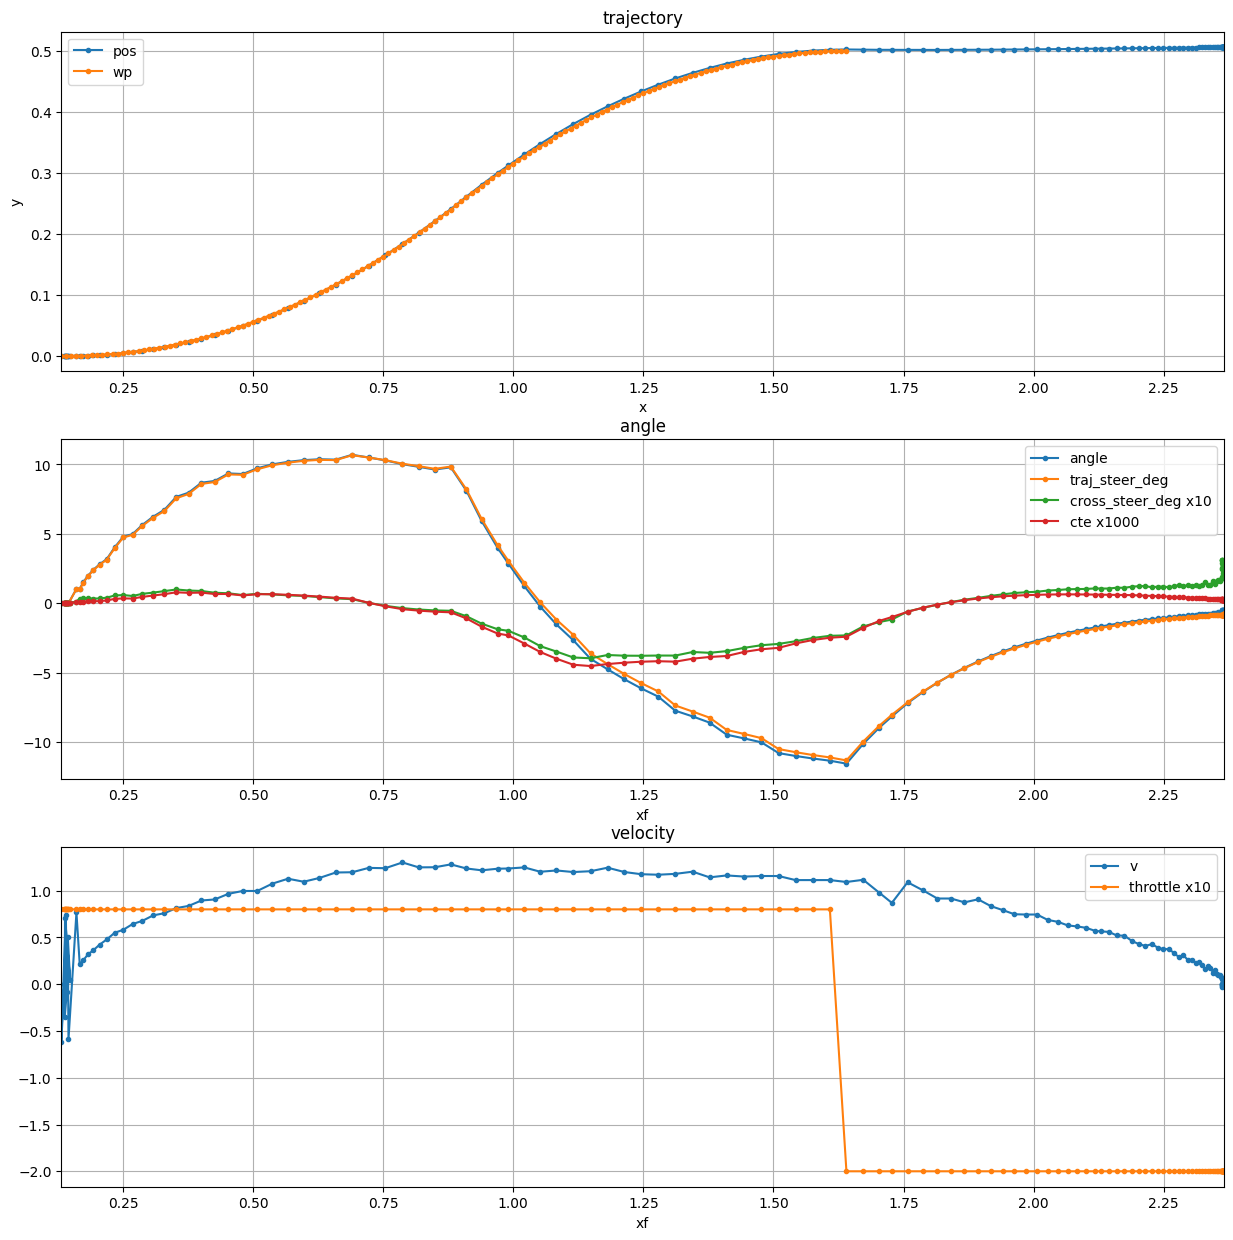

In [87]:
fig, ax = plt.subplots(3, 1)
fig.set_figwidth(15)
fig.set_figheight(15)
#fig.suptitle('States')
ax[0].plot(xf, yf, label='pos', marker='.')
ax[0].plot(waypoints[:,0], waypoints[:,1], label='wp', marker='.')
ax[0].legend()
ax[0].set_title('trajectory')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].grid()
ax[0].set_xlim([np.min(xf), np.max(xf)])
#ax[0].axis('equal')

x_axis = xf #t-t[0]
ax[1].plot(x_axis, angle_deg, label='angle', marker='.')
ax[1].plot(x_axis, traj_steer_deg, label='traj_steer_deg', marker='.')
ax[1].plot(x_axis, cross_steer_deg * 10, label='cross_steer_deg x10', marker='.')
ax[1].plot(x_axis, cte * 1000, label='cte x1000', marker='.')
ax[1].legend()
ax[1].set_title('angle')
ax[1].set_xlabel('xf')
#ax[1].axhline(0, color='black')
ax[1].set_xlim([np.min(x_axis), np.max(x_axis)])
ax[1].grid()

ax[2].plot(x_axis, v, label='v', marker='.')
ax[2].plot(x_axis, throttle * 10, label='throttle x10', marker='.')
#ax[2].plot(x_axis, end.astype(int), label='end of path', marker='.')
ax[2].legend()
ax[2].set_title('velocity')
ax[2].set_xlabel('xf')
#ax21].axhline(0, color='black')
ax[2].set_xlim([np.min(x_axis), np.max(x_axis)])
ax[2].grid()

print('Final position: x: {:.3f} m, y: {:.3f} m, theta: {:.2f} deg'.format(x[-1], y[-1], yaw_deg[-1]))

(165,)
(165,)
(165,)
(165,)


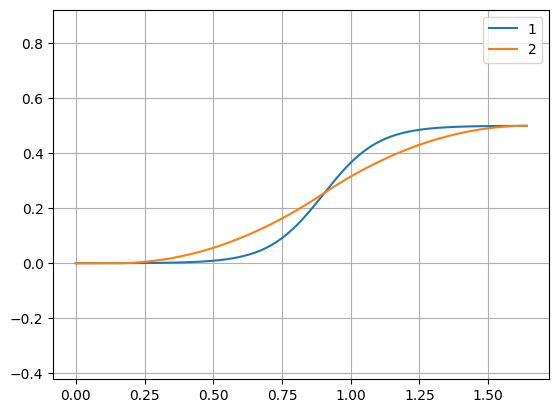

In [36]:
def sigmoid(x):
        return 1 / (1 + math.exp(-x))

def generate_path_sigmoid():
        x = np.array([x for x in range(150)]) / 100
        y = np.array([ sigmoid((x-75)/10) for x in range(150)]) / 2
        p = np.vstack((x,y)).T
        return p
    
def generate_path_w_trapeze():
        x = np.array([x for x in range(150)]) / 100
        y = [0]
        for i in range(1, 150):
                y.append(y[-1] + (i if i < 75 else 150 - i))
        y = np.array(y) / (2 * max(y))
        p = np.vstack((x,y)).T
        return p

def shift_x(p):
        n = 15
        x = np.concatenate([np.array([x for x in range(n)])/100, p[:,0] + n/100])
        y = np.concatenate([np.array([0] * n), p[:,1]])
        print(x.shape)
        print(y.shape)
        p = np.vstack((x,y)).T
        return p

p1 = shift_x(generate_path_sigmoid())
p2 = shift_x(generate_path_w_trapeze())

x_ = p1[:,0]
y_ = p1[:,1]
plt.plot(x_, y_, label='1')

x_ = p2[:,0]
y_ = p2[:,1]
plt.plot(x_, y_, label='2')

plt.legend()
plt.grid()
plt.axis('equal')
plt.show()